## Define Function and its Symmetry

In [1]:
import random

import torch
import matplotlib.pyplot as plt

from constants import DTYPE

## Generate Dataset

In [2]:
N_SAMPLES = 100_000
n_features = 2
LAMBDA = 1
RHO = 1

SYMMETRY_DIM = 1

cost_matrix = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=DTYPE)

def f(state, cost_matrix=cost_matrix):
    """Evaluates f:M \rightarrow N for a batch of states s and a cost_matrix.
    Args:
        state: torch.Tensor of shape (batch_size, n_features)
    Returns:
        torch.Tensor of shape (batch_size,)
    """
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)

p = torch.randn(N_SAMPLES, n_features, dtype=DTYPE)
n = f(p)

## Differential Symmetry Discovery

### Step 1: Learn Basis of Kernel at each Point

In [3]:
KERNEL_DIM=1
EPSILON_BALL = 0.05
EPSILON_LEVEL_SET = 0.005

from src.learning.symmetry_discovery.differential.kernel_pprox import pointwise_kernel_approx

kernel_bases = pointwise_kernel_approx(p=p, n=n, kernel_dim=KERNEL_DIM, epsilon_ball=EPSILON_BALL, epsilon_level_set=EPSILON_LEVEL_SET)

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/kernel_pprox.py:62: UserWarning: Kernel Approximation currently only supports real-valued functions.
  warnings.warn("Kernel Approximation currently only supports real-valued functions.")
100%|██████████| 100000/100000 [00:05<00:00, 17066.37it/s]
INFO:root:Computed kernel bases from:
  - multiple tangent vectors for 67.08% of samples (good)
  - one tangent vector for 13.51% of samples (okay)
  - no tangent vector for 19.41% of samples (not good, no basis).


## Step 2: Learning the Generator

In [4]:
from src.learning.symmetry_discovery.differential.diff_generator import DiffGenerator

g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
g_0 = torch.nn.Parameter(g_init_all)
optimizer = torch.optim.Adam([g_0], lr=0.00045)

diff_generator = DiffGenerator(
    g_0=g_0,
    p=p,
    bases=kernel_bases,
    batch_size=128,
    n_steps = 20_000,
    optimizer=optimizer
)
g_star_diff = diff_generator.optimize()

100%|██████████| 20000/20000 [00:18<00:00, 1073.77it/s]


# Learned Kernel

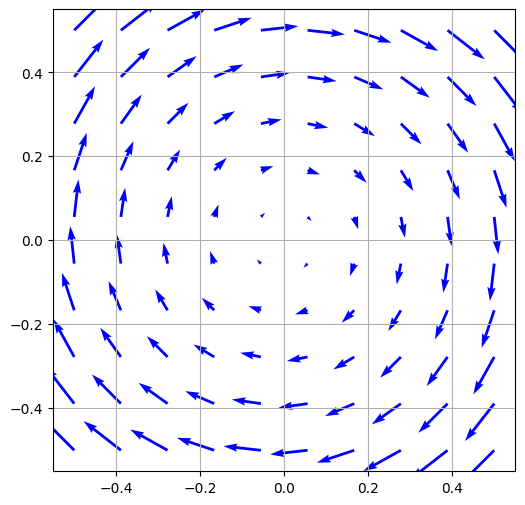

In [6]:
from src.plotting.differential.vector_field import plot_learned_generator

fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)

plot_learned_generator(generator=diff_generator.g, ax=axes, quiver_scale=2)

## Functional Symmetry Discovery

In [5]:
from src.learning.symmetry_discovery.functional.func_generator import FuncGenerator

g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
g_init_all = torch.tensor([[0.0, -1.0], [1.0,0.0]]).unsqueeze(0)
g_0 = torch.nn.Parameter(g_init_all)
optimizer_func = torch.optim.Adam([g_0], lr=0.00045)

func_generator = FuncGenerator(
    g_0=g_0,
    p=p,
    f=f,
    batch_size=128,
    optimizer=optimizer_func,
    n_steps = 5_000,
)

g_star_func = func_generator.optimize()

100%|██████████| 5000/5000 [00:13<00:00, 380.97it/s]


## Compare Both Approaches

In [29]:
class DiffFuncGenerator(DiffGenerator, FuncGenerator):
    """Learns a differential generator via both differential and functional symmetry discovery."""

    def __init__(self, 
                 g_0, 
                 p, 
                 bases,
                 func,
                 batch_size: int,
                 g_oracle,
                 n_steps: int):
        
        self.g_0_diff = torch.nn.Parameter(g_0.clone().detach().requires_grad_(True))
        self.g_0_func = torch.nn.Parameter(g_0.clone().detach().requires_grad_(True))

        self.optimizer_diff = torch.optim.Adam([self.g_0_diff], lr=0.00045)
        self.optimizer_func = torch.optim.Adam([self.g_0_func], lr=0.00045)

        DiffGenerator.__init__(self, self.g_0_diff, p, bases, batch_size, n_steps, optimizer=self.optimizer_diff)
        FuncGenerator.__init__(self, self.g_0_func, p, func, batch_size, n_steps=n_steps, optimizer=self.optimizer_func)

        self.p = p
        self.bases = bases
        self.func = func
        self.batch_size = batch_size,
        self.n_steps = n_steps
        self.g_oracle = g_oracle

        self.func_losses = []
        self.diff_losses = []
        self.oracle_losses = []

        self.func_losses_symmetry = []
        self.diff_losses_symmetry = []
        self.oracle_losses_symmetry = []

        self.func_losses_maximal = []
        self.diff_losses_maximal = []
        self.oracle_losses_maximal = []


    def take_one_gradient_step(self,
                               p_batch,
                               bases_batch,
                               group_coeffs_batch):
        """Takes a gradient step via both differental and functional symmetry discovery on the same data (but different generators)."""

        # Gradient Update.
        self.take_one_gradient_step_diff(generator=self.g_0_diff, p_batch=p_batch, bases_batch=bases_batch)
        self.take_one_gradient_step_func(generator=self.g_0_func, p_batch=p_batch, group_coeffs_batch=group_coeffs_batch, take_gradient_step=True)


    def evaluate_generator(self, p_batch, generator, oracle_generator):
        """Evaluates a learned generator against a ground truth generator by checking whether they span the same subspaces at different points."""
        
        def project_onto_subspace(vecs, basis):
            """Projects a set of vectors into a vector space spanned by basis.
            vecs: tensor of shape (b,d,n)
            basis: tensor of shape (b,d,n)
            """
            basis_t = basis.transpose(1, 2)  #(b,n,d)
            
            # Compute Gram matrix and its pseudo-inverse: (b,d,d)
            G = torch.matmul(basis, basis_t)  # (b,d,d)
            G_inv = torch.linalg.pinv(G)

            # Compute projection matrix: (b,n,n)
            P = torch.matmul(basis_t, torch.matmul(G_inv, basis))  # (b,n,n)
            
            # Project vecs: (b,d,n)
            return torch.matmul(vecs, P)  # (b,d,n)
        
        # Step 0: Batch
        generator_batched = generator.unsqueeze(0)
        generator_batched = generator_batched.repeat(self._batch_size, 1, 1, 1)
        oracle_generator_batched = oracle_generator.unsqueeze(0)
        oracle_generator_batched = oracle_generator_batched.repeat(self._batch_size, 1, 1, 1)
        
        # Step 0: Evaluate the generators at different points:
        generator_ps = torch.einsum('bdnm,bm->bdn', generator_batched, p_batch)
        oracle_generator_ps = torch.einsum('bdnm,bm->bdn', oracle_generator_batched, p_batch)

        # Step 1: Check whether generator is a subspace of oracle generator at different points
        proj_gen_on_oracle = project_onto_subspace(generator_ps, oracle_generator_ps)
        orth_gen_on_oracle = generator_ps - proj_gen_on_oracle

        # Step 2: Check whether oracle generator is a subspace of generator
        proj_oracle_on_gen = project_onto_subspace(oracle_generator_ps, generator_ps)
        orth_oracle_on_gen = oracle_generator_ps - proj_oracle_on_gen

        loss_symmetry = torch.sum(torch.norm(orth_gen_on_oracle, dim=(1,2)), dim=0)
        loss_maximal = torch.sum(torch.norm(orth_oracle_on_gen, dim=(1,2)), dim=0)

        return loss_symmetry, loss_maximal, loss_symmetry + loss_maximal


    def sample_data(self):
        """"Samples batch size points from the manifold, kernel basis vector and coeffs for group actions."""
        _bases_idxs = list(self.bases.keys()) #Only sample from those points where we estimated a basis.
        idxs = random.sample(_bases_idxs, self._batch_size)
        p_batch = self.p[idxs]

        # Bases for differential discovery
        bases_batch = torch.vstack([self.bases[i] for i in idxs]).unsqueeze(-1) #(b, n, d)
        bases_batch = self._normalize_tensor(tensor=bases_batch, dim=(1,2))

        # Group actions for functional discovery
        # TODO, currently for symmetry group, change range from 2pi to arbitrary coefficients.
        group_coeffs_batch = torch.rand((self._batch_size, self._group_dim))*2*torch.pi

        return p_batch, bases_batch, group_coeffs_batch
            

    def optimize(self):

        for _ in range(self.n_steps):

            #1. Sample data
            p_batch, bases_batch, group_coeffs_batch = self.sample_data()

            #2. Take Gradient step.
            self.take_one_gradient_step(p_batch=p_batch, bases_batch=bases_batch, group_coeffs_batch=group_coeffs_batch)
            del p_batch, bases_batch, group_coeffs_batch

            #3. Evaluate on fresh data
            p_batch, _, _ = self.sample_data()
            with torch.no_grad():
                # Normalize as length of orthogonal component depends on length of basis.
                self.g_0_diff_norm = self._normalize_tensor(self.g_0_diff, dim=(1,2))
                self.g_0_func_norm = self._normalize_tensor(self.g_0_func, dim=(1,2))
                loss_diff_symmetry, loss_diff_maximal, loss_diff = self.evaluate_generator(p_batch, self.g_0_diff_norm, self.g_oracle)
                loss_func_symmetry, loss_func_maximal, loss_func = self.evaluate_generator(p_batch, self.g_0_func_norm, self.g_oracle)
                # TODO: hard-coded oracle prime, change this to a rotation of self.g_oracle
                g_oracle_prime = torch.tensor([[0, 1], [-1, 0]], dtype=DTYPE).unsqueeze(0)
                loss_oracle_symmetry, loss_oracle_maximal, loss_oracle = self.evaluate_generator(p_batch, g_oracle_prime, self.g_oracle)


                self.diff_losses.append(loss_diff.detach().numpy())
                self.func_losses.append(loss_func.detach().numpy())
                self.oracle_losses.append(loss_oracle.detach().numpy())

                self.diff_losses_symmetry.append(loss_diff_symmetry.detach().numpy())
                self.func_losses_symmetry.append(loss_func_symmetry.detach().numpy())
                self.oracle_losses_symmetry.append(loss_oracle_symmetry.detach().numpy())

                self.diff_losses_maximal.append(loss_diff_maximal.detach().numpy())
                self.func_losses_maximal.append(loss_func_maximal.detach().numpy())
                self.oracle_losses_maximal.append(loss_oracle_maximal.detach().numpy())

# g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
# g_0 = torch.nn.Parameter(g_init_all)
# g_oracle = torch.tensor([[0, -1], [1, 0]], dtype=DTYPE).unsqueeze(0)

# diff_func_generator = DiffFuncGenerator(
#     g_0=g_0,
#     p=s,
#     bases=basis,
#     func=f,
#     batch_size=128,
#     n_steps = 10_000,
#     g_oracle=g_oracle
# )
# diff_func_generator.optimize()

In [177]:
g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
g_0 = torch.nn.Parameter(g_init_all)
g_oracle = torch.tensor([[0, -1], [1, 0]], dtype=DTYPE).unsqueeze(0)

diff_func_generator = DiffFuncGenerator(
    g_0=g_0,
    p=s,
    bases=basis,
    func=f,
    batch_size=128,
    n_steps = 25_000,
    g_oracle=g_oracle
)
diff_func_generator.optimize()

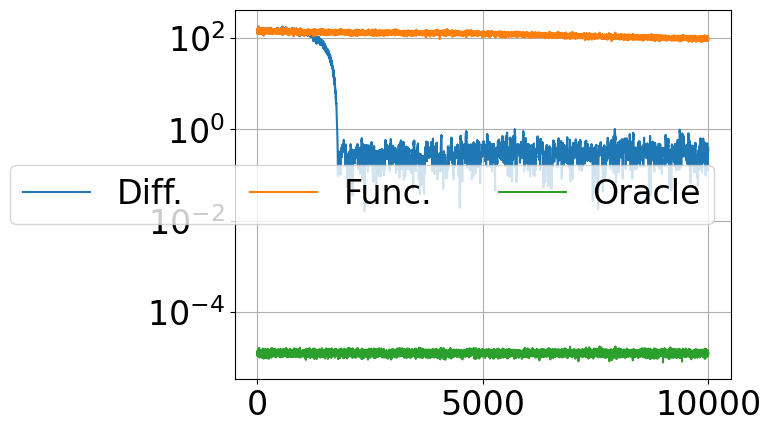

In [14]:
plt.plot(diff_func_generator.diff_losses, label="Diff.")
plt.plot(diff_func_generator.func_losses, label="Func.")
plt.plot(diff_func_generator.oracle_losses, label="Oracle")
plt.yscale("log")
plt.grid()
plt.legend(loc="best", ncols=3)

In [33]:
diff_func_generators = []
N_RUNS = 3
N_STEPS = 30_000

for idx_run in range(N_RUNS):
    print(f"Run {idx_run+1} out of {N_RUNS}")

    g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
    g_0 = torch.nn.Parameter(g_init_all)
    g_oracle = torch.tensor([[0, -1], [1, 0]], dtype=DTYPE).unsqueeze(0)

    diff_func_generator = DiffFuncGenerator(
        g_0=g_0,
        p=s,
        bases=basis,
        func=f,
        batch_size=128,
        n_steps = N_STEPS,
        g_oracle=g_oracle
    )
    diff_func_generator.optimize()
    diff_func_generators.append(diff_func_generator)

Run 1 out of 3
Run 2 out of 3
Run 3 out of 3


## Plotting

In [47]:
losses_symmetry["diff"].shape

(3, 30000)

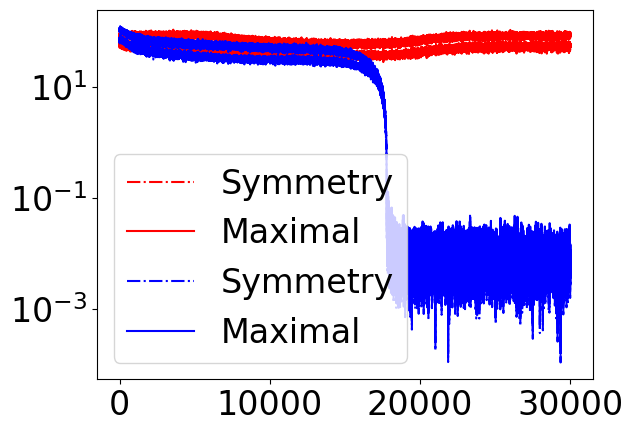

In [55]:
idx_generator = 0

plt.plot(losses_symmetry["func"][idx_generator,:], label="Symmetry", color="red", linestyle="-.")
plt.plot(losses_maximal["func"][idx_generator,:], label="Maximal", color="red", linestyle="-")

idx_generator = 1

plt.plot(losses_symmetry["func"][idx_generator,:], label="Symmetry", color="blue", linestyle="-.")
plt.plot(losses_maximal["func"][idx_generator,:], label="Maximal", color="blue", linestyle="-")
plt.yscale("log")
plt.legend()

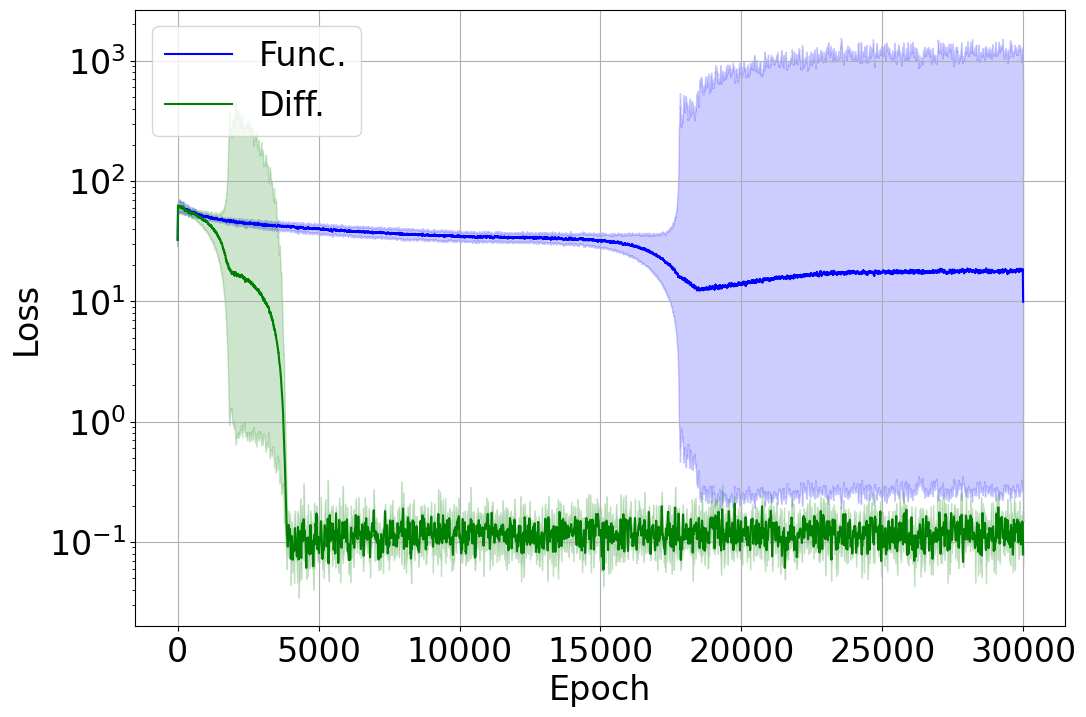

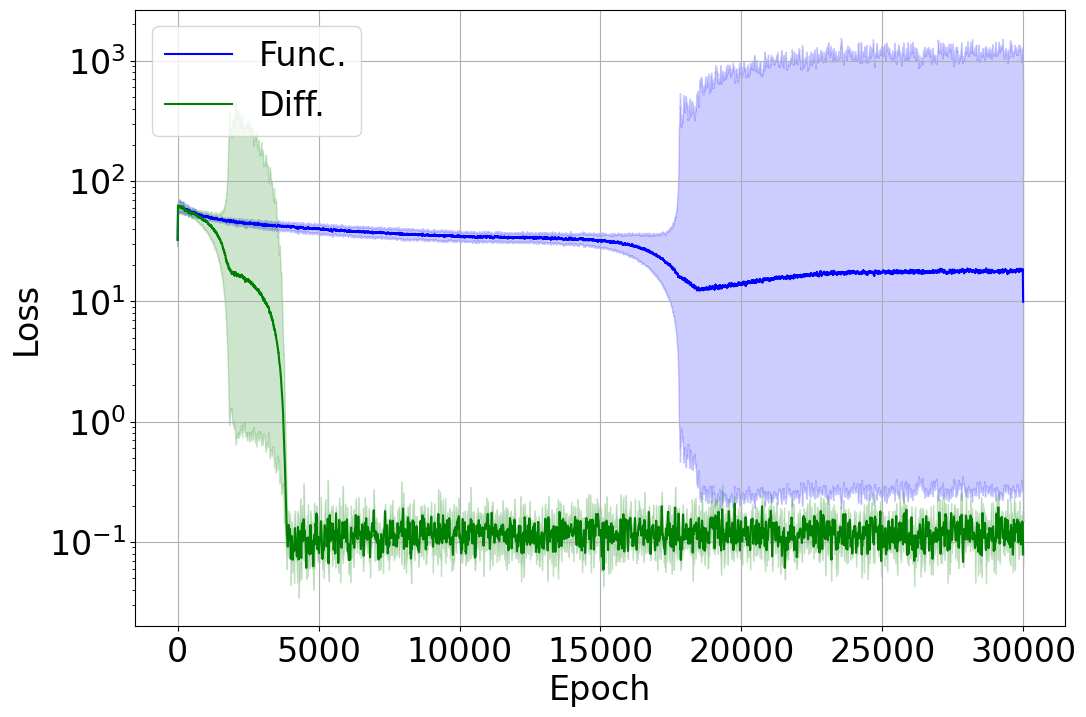

In [42]:
def losses_to_np(diff_func_generators, loss_type, mode):
        
    losses = np.zeros(shape=(N_RUNS, N_STEPS))
    if loss_type=="diff" and mode=="symmetry":
        for idx in range(N_RUNS):
            losses[idx, :] = diff_func_generators[idx].diff_losses_symmetry
    elif loss_type=="diff" and mode=="maximal":
        for idx in range(N_RUNS):
            losses[idx, :] = diff_func_generators[idx].diff_losses_maximal
    elif loss_type=="func" and mode=="symmetry":
        for idx in range(N_RUNS):
            losses[idx, :] = diff_func_generators[idx].func_losses_symmetry
    elif loss_type=="func" and mode=="maximal":
        for idx in range(N_RUNS):
            losses[idx, :] = diff_func_generators[idx].func_losses_maximal
    return losses

def compute_mean_and_std_losses(losses, window_size):
    """"""

    def moving_average(arr, window_size):
        kernel = np.ones(window_size) / window_size
        return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=1, arr=arr)
    
    def compute_mean_and_std_loss(losses):
        mean_losses_smoothed = moving_average(losses, window_size).mean(axis=0)
        log_std_losses_smoothed = np.exp(np.std(np.log(moving_average(losses, window_size) + 1e-8), axis=0))
        return mean_losses_smoothed, log_std_losses_smoothed

    mean_loss_funcs, log_std_loss_funcs = compute_mean_and_std_loss(losses["func"])
    mean_loss_vec_fields, log_std_loss_vec_fields = compute_mean_and_std_loss(losses["diff"])

    losses = {}
    losses['loss_func'] = {}
    losses['loss_vec_field'] = {}
    losses['loss_oracle'] = {}

    losses['loss_func']['mean'] = mean_loss_funcs
    losses['loss_func']['log_std'] = log_std_loss_funcs
    losses['loss_vec_field']['mean'] = mean_loss_vec_fields
    losses['loss_vec_field']['log_std'] = log_std_loss_vec_fields

    return losses

def plot_losses(losses):

    plt.figure(figsize=(12, 8))
    loss_types = ['loss_func', 'loss_vec_field']
    loss_names = ['Func.', 'Diff.', 'Oracle']
    colors = ['blue', 'green', 'red']

    for idx_loss_type, loss_type in enumerate(loss_types):
        mean_losses = losses[loss_type]['mean']
        log_std_losses = losses[loss_type]['log_std']
        plt.plot(mean_losses, label=loss_names[idx_loss_type], color=colors[idx_loss_type])
        plt.fill_between(range(len(mean_losses)), mean_losses / log_std_losses, mean_losses * log_std_losses, alpha=0.2, color=colors[idx_loss_type])


    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

losses_diff_symmetry = losses_to_np(diff_func_generators, "diff", "symmetry")
losses_func_symmetry = losses_to_np(diff_func_generators, "func", "symmetry")
losses_oracle_symmetry = losses_to_np(diff_func_generators, "oracle", "symmetry")

losses_diff_maximal = losses_to_np(diff_func_generators, "diff", "maximal")
losses_func_maximal = losses_to_np(diff_func_generators, "func", "maximal")
losses_oracle_maximal = losses_to_np(diff_func_generators, "oracle", "maximal")

losses_symmetry = {}
losses_symmetry["diff"] = losses_diff_symmetry
losses_symmetry["func"] = losses_func_symmetry
losses_symmetry["oracle"] = losses_oracle_symmetry

losses_maximal = {}
losses_maximal["diff"] = losses_diff_maximal
losses_maximal["func"] = losses_func_maximal
losses_maximal["oracle"] = losses_oracle_maximal

losses_stats_symmetry = compute_mean_and_std_losses(losses_symmetry, window_size=25)
losses_stats_maximal = compute_mean_and_std_losses(losses_maximal, window_size=25)

plot_losses(losses_stats_symmetry)
plot_losses(losses_stats_maximal)


In [40]:
losses_stats_symmetry

{'loss_func': {'mean': array([32.3943721 , 34.82130768, 37.32607778, ..., 11.32601838,
         10.65003333,  9.9214015 ]),
  'log_std': array([ 1.12466633,  1.12989627,  1.13225634, ..., 65.88038023,
         66.77337524, 67.33459621])},
 'loss_vec_field': {'mean': array([32.39389882, 34.82100993, 37.32557531, ...,  0.09017379,
          0.08491013,  0.07869858]),
  'log_std': array([1.12401489, 1.12919323, 1.13154468, ..., 1.26054103, 1.25590007,
         1.24632495])},
 'loss_oracle': {}}

In [41]:
losses_stats_maximal

{'loss_func': {'mean': array([47.99561646, 51.64483836, 55.23927958, ..., 17.07833433,
         16.01301102, 14.94193314]),
  'log_std': array([ 1.13185759,  1.13554201,  1.13697673, ..., 67.8990839 ,
         68.72682134, 69.35850883])},
 'loss_vec_field': {'mean': array([47.98639526, 51.63495799, 55.22759674, ...,  0.12752143,
          0.12007797,  0.11129339]),
  'log_std': array([1.13156461, 1.13523493, 1.1366671 , ..., 1.26050671, 1.25586381,
         1.24628575])},
 'loss_oracle': {}}

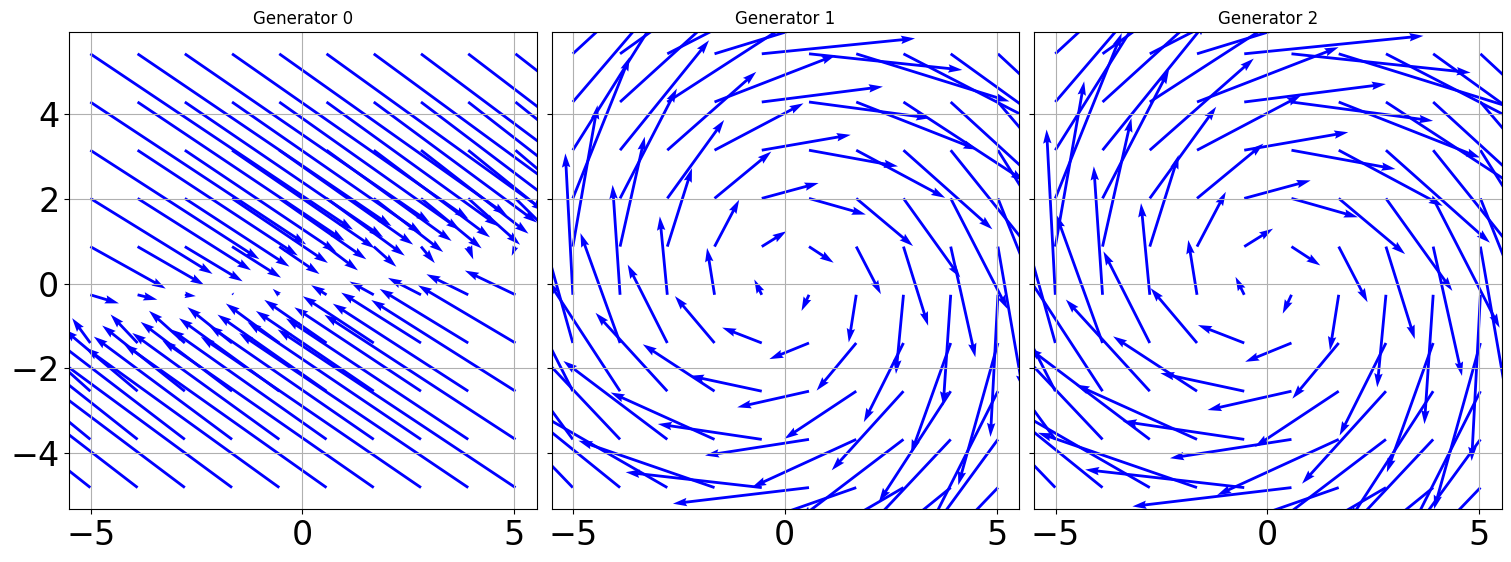

In [62]:
def plot_loss(generators):

    fig, axes = plt.subplots(1, 5, figsize=(15, 6), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flat):
        ax.plot(generators[i]._losses)
        ax.set_title(f"Loss g_plus {i} symmetry")
        ax.set_yscale("log")

def plot_vector_field(generators):

    fig, axes = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True, sharex= True, sharey=True)
    for i, ax in enumerate(axes.flat):
        plot_learned_generator(diff_func_generators[i].g_0_func, ax, title=f"Generator {i}", quiver_scale=1)

# plot_loss(diff_generators)
# plot_vector_field(diff_generators)

# plot_loss(func_generators)
plot_vector_field(func_generators)